In [2]:
import pandas as pd
import json

df_channels = pd.read_csv('df_channels_en.tsv', sep='\t')
print(df_channels.head())
print(df_channels.info())

     category_cc   join_date                   channel  \
0         Gaming  2010-04-29  UC-lHJZR3Gqxm24_Vd_AJ5Yw   
1      Education  2006-09-01  UCbCmjCuTUZos6Inko4u57UQ   
2  Entertainment  2006-09-20  UCpEhnqL0y41EpW2TvWAHD7Q   
3  Howto & Style  2016-11-15  UC295-Dw_tDNtZXFeAPAW6Aw   
4         Sports  2007-05-11  UCJ5v_MCY6GNUBTO8-D3XoAg   

                   name_cc  subscribers_cc  videos_cc  subscriber_rank_sb  \
0                PewDiePie       101000000       3956                 3.0   
1  Cocomelon - Nursery ...        60100000        458                 7.0   
2                SET India        56018869      32661                 8.0   
3          5-Minute Crafts        60600000       3591                 9.0   
4                      WWE        48400000      43421                11.0   

   weights  
0    2.087  
1    2.087  
2    2.087  
3    2.087  
4    2.087  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136470 entries, 0 to 136469
Data columns (total 8 columns):


In [ ]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

df_metadata = load_jsonl('yt_metadata_filtered_"trump ".jsonl')

df_metadata.rename(columns={'channel_id': 'channel'}, inplace=True)

print(df_metadata.head())
print(df_metadata.info())

  categories                   channel                  crawl_date  \
0     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.001044   
1     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.563584   
2     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:36.350067   
3     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:36.930863   
4     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:39.777410   

  description  dislike_count   display_id  duration  like_count  \
0                        6.0  iWbFNJaaHrw       270        47.0   
1                        8.0  MRaGK43Ux-k       109        52.0   
2                        4.0  -91qrjpgRw0        58        26.0   
3                        8.0  nq9_WZXjjCI        71        25.0   
4                       24.0  Kh-s-TEnqWY      7508        43.0   

                                                tags  \
0  video,games,retrogamer3,ed,findlay,Trump,Ameri...   
1  video,games,retrogamer3,ed,findlay,America's R...   
2  video

In [8]:
df_channels.dropna(subset=['channel'], inplace=True)
df_metadata.fillna({'description': '', 'tags': '', 'keywords': ''}, inplace=True)


# 去重
df_channels.drop_duplicates(subset=['channel'], inplace=True)
df_metadata.drop_duplicates(subset=['display_id'], inplace=True)


# 统一频道ID格式
df_channels['channel'] = df_channels['channel'].str.upper()
df_metadata['channel'] = df_metadata['channel'].str.upper()


# 合并频道与视频数据
df_combined = pd.merge(df_metadata, df_channels, left_on='channel', right_on='channel', how='left')

# 检查合并结果
print(len(df_metadata))
print(len(df_combined))
print(df_combined.head(1))


447616
447616
  categories                   channel                  crawl_date  \
0     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:33.001044   

  description  dislike_count   display_id  duration  like_count  \
0                        6.0  iWbFNJaaHrw       270        47.0   

                                                tags  \
0  video,games,retrogamer3,ed,findlay,Trump,Ameri...   

                                   title          upload_date  view_count  \
0  America's Retribution Term 2 Launched  2019-05-08 00:00:00       445.0   

  keywords category_cc   join_date     name_cc  subscribers_cc  videos_cc  \
0   trump       Gaming  2008-07-18  Ed Findlay           11884        311   

   subscriber_rank_sb  weights  
0            857247.0  14.1935  


In [10]:
print(df_combined.columns)

Index(['categories', 'channel', 'crawl_date', 'description', 'dislike_count',
       'display_id', 'duration', 'like_count', 'tags', 'title', 'upload_date',
       'view_count', 'keywords', 'category_cc', 'join_date', 'name_cc',
       'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')


In [13]:
import re

# 阴谋论定义
conspiracy_definitions = {
    "conspiracy_theories": [
        {
            "name": "Deep State",
            "description": "Refers to a hidden powerful faction within the government allegedly working to undermine Trump and his supporters."
        },
        {
            "name": "Election Fraud",
            "description": "Claims of widespread election fraud, especially in the 2020 presidential election, focusing on alleged issues with mail-in ballots."
        },
        {
            "name": "QAnon",
            "description": "While not explicitly endorsed, Trump has shown indirect support for followers of QAnon, a conspiracy about a deep-rooted cabal involved in child trafficking and satanic rituals."
        },
        {
            "name": "Missing Emails",
            "description": "Refers to the 2016 scandal involving Hillary Clinton’s deleted emails, which Trump frequently highlighted."
        },
        {
            "name": "Biden Family Scandal",
            "description": "Claims of corruption within the Biden family, particularly involving Hunter Biden’s business dealings and alleged exploitation of Biden’s influence."
        },
        {
            "name": "Climate Change Hoax",
            "description": "Skepticism toward climate change, suggesting it's a 'hoax' promoted by global elites for profit."
        }
    ]
}

# 基于名称及其高度相关的词语创建关键词字典
conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}

import json
print("\nconspiracy_keywords:")
print(json.dumps(conspiracy_keywords, indent=2, ensure_ascii=False))


conspiracy_keywords:
{
  "Deep State": [
    "deepstate",
    "deep state",
    "government faction",
    "shadow government",
    "hidden government"
  ],
  "Election Fraud": [
    "election fraud",
    "vote fraud",
    "mail-in ballots",
    "voter suppression",
    "rigged election"
  ],
  "QAnon": [
    "qanon",
    "cabal",
    "child trafficking",
    "satanic rituals",
    "deep-rooted cabal",
    "Q movement"
  ],
  "Missing Emails": [
    "missing emails",
    "deleted emails",
    "clinton emails",
    "email scandal",
    "email leak"
  ],
  "Biden Family Scandal": [
    "biden family scandal",
    "hunter biden",
    "biden corruption",
    "biden business dealings",
    "biden influence"
  ],
  "Climate Change Hoax": [
    "climate change hoax",
    "global elites",
    "climate profit",
    "false climate",
    "climate deception"
  ]
}


In [14]:

# check if a text contains any of the conspiracy
def detect_conspiracy_types(row, keywords_dict):
    # 合并相关文本字段
    text = ' '.join([str(row['title']), str(row['description']), str(row['tags'])]).lower()
    detected = {}
    for theory, keywords in keywords_dict.items():
        # 使用正则表达式进行匹配
        pattern = re.compile('|'.join([re.escape(word) for word in keywords]), re.IGNORECASE)
        if pattern.search(text):
            detected[theory] = 1
            continue
        else:
            detected[theory] = 0
    return pd.Series(detected)


In [15]:
# Initialize list to store records with conspiracy keywords
df_combined = df_combined.fillna({'title': '', 'description': '', 'tags': '', 'keywords': ''})

conspiracy_detection = df_combined.apply(lambda row: detect_conspiracy_types(row, conspiracy_keywords), axis=1)
df_combined_with_conspiracy = pd.concat([df_combined, conspiracy_detection], axis=1)

# 添加一个总的阴谋论标记
df_combined_with_conspiracy['is_conspiracy'] = df_combined_with_conspiracy[list(conspiracy_keywords.keys())].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# 查看结果
print("\nconspiracy_detection:")
print(df_combined_with_conspiracy[['title', 'is_conspiracy'] + list(conspiracy_keywords.keys())].head())

print("\nconspiracy_detection_overall:")
print(df_combined_with_conspiracy['is_conspiracy'].value_counts())




conspiracy_detection:
                                     title  is_conspiracy  Deep State  \
0    America's Retribution Term 2 Launched              0           0   
1      America's Retribution Term 2 promo!              0           0   
2  The last mini boss is done. The fuhrer.              0           0   
3          Elizabeth Warren Boss Finished!              0           0   
4           America's Retribution -Stream-              0           0   

   Election Fraud  QAnon  Missing Emails  Biden Family Scandal  \
0               0      0               0                     0   
1               0      0               0                     0   
2               0      0               0                     0   
3               0      0               0                     0   
4               0      0               0                     0   

   Climate Change Hoax  
0                    0  
1                    0  
2                    0  
3                    0  
4               

In [17]:

# print(conspiracy_df.describe())

# category_counts = conspiracy_df['categories'].value_counts()
# print("\nCategory distribution for conspiracy videos:")
# print(category_counts)
print(df_combined_with_conspiracy.columns)
print(df_combined_with_conspiracy.head())
print(df_combined_with_conspiracy.info())



Index(['categories', 'channel', 'crawl_date', 'description', 'dislike_count',
       'display_id', 'duration', 'like_count', 'tags', 'title', 'upload_date',
       'view_count', 'keywords', 'category_cc', 'join_date', 'name_cc',
       'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights',
       'Deep State', 'Election Fraud', 'QAnon', 'Missing Emails',
       'Biden Family Scandal', 'Climate Change Hoax', 'is_conspiracy'],
      dtype='object')
  categories                   channel                  crawl_date  \
0     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:33.001044   
1     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:33.563584   
2     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:36.350067   
3     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:36.930863   
4     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:39.777410   

  description  dislike_count   display_id  duration  like_count  \
0                        6.0  iWbFNJaaHrw       270 

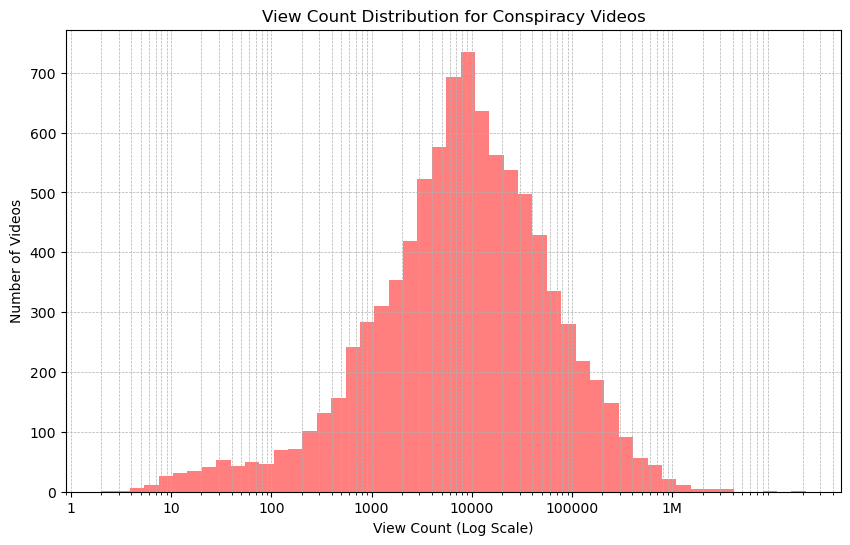

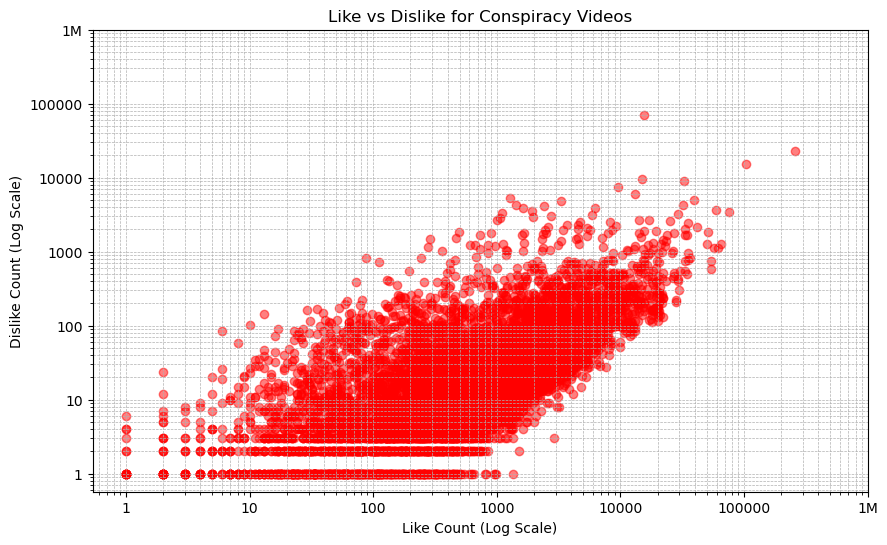

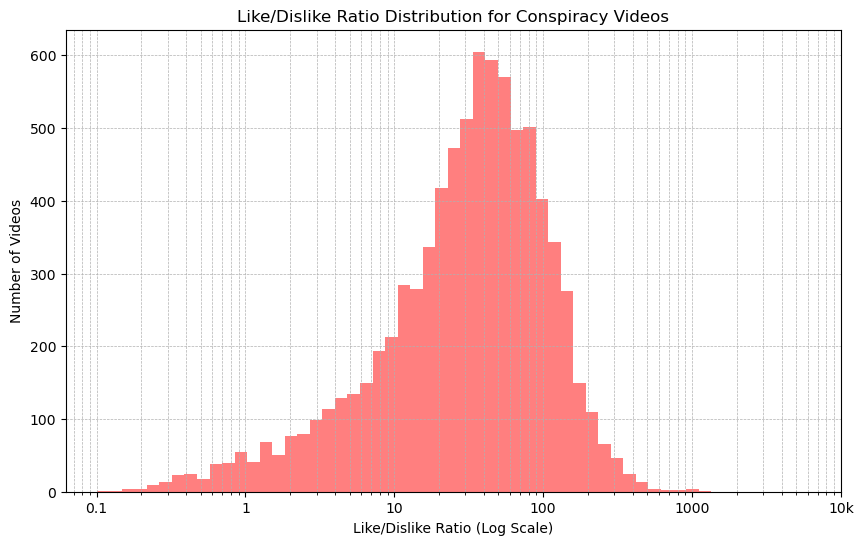

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# View count distribution for conspiracy videos with logarithmic x-axis
plt.figure(figsize=(10, 6))

# Remove zero or negative values to avoid issues with the logarithmic scale
view_counts = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['view_count']
view_counts = view_counts[view_counts > 0]

plt.hist(view_counts, bins=np.logspace(np.log10(view_counts.min()), np.log10(view_counts.max()), 50), alpha=0.5, color='r', label='Conspiracy Videos')
plt.xscale('log')
plt.xticks([1, 10, 100, 1000, 10000, 100000, 1000000], labels=[1, 10, 100, 1000, 10000, 100000, '1M'])
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

# Like vs Dislike scatter plot for conspiracy videos with logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.scatter(df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['like_count'],
            df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['dislike_count'],
            color='r', alpha=0.5)
plt.xscale('log')  # Set x-axis to logarithmic scale for likes
plt.yscale('log')  # Set y-axis to logarithmic scale for dislikes
plt.xticks([1, 10, 100, 1000, 10000, 100000, 1000000], labels=[1, 10, 100, 1000, 10000, 100000, '1M'])
plt.yticks([1, 10, 100, 1000, 10000, 100000, 1000000], labels=[1, 10, 100, 1000, 10000, 100000, '1M'])
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Dislike Count (Log Scale)')
plt.title('Like vs Dislike for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

# Like/Dislike ratio distribution for conspiracy videos
# Avoid division by zero by replacing 0 dislikes with a small number (or filtering them out)
like_count = df_combined_with_conspiracy['like_count']
dislike_count = df_combined_with_conspiracy['dislike_count']
dislike_count = dislike_count.replace(0, np.nan)  # Replace 0 dislikes with NaN to avoid division issues

# Calculate ratio, dropping NaNs (resulting from zero dislikes)
df_combined_with_conspiracy['like_dislike_ratio'] = like_count / dislike_count
ratio_data = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['like_dislike_ratio'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(ratio_data, bins=np.logspace(-1, np.log10(ratio_data.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100, 1000, 10000], labels=[0.1, 1, 10, 100, 1000, '10k'])
plt.xlabel('Like/Dislike Ratio (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


In [33]:
# get non-conspiracy records
# non_conspiracy_records = [data for data in feature_data if not contains_conspiracy(data.get('title', ''), conspiracy_keywords)]

# # Create DataFrame for non-conspiracy records
# non_conspiracy_df = pd.DataFrame(non_conspiracy_records)
pd.set_option('display.float_format', '{:,.2f}'.format)
# # Display the first few rows of the DataFrame
# print("\nNon-conspiracy records:")
# print(conspiracy_df.describe())

# print("\nNon-conspiracy records:")
# print(non_conspiracy_df.describe())
non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]
# print(non_conspiracy_df.info())
# print(non_conspiracy_df.describe())
print('without conspiracy')
print(non_conspiracy_df['view_count'].describe())
print('with conspiracy')
print(df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['view_count'].describe())


without conspiracy
count       438,502.00
mean         63,287.61
std         794,433.20
min               0.00
25%             712.00
50%           3,983.00
75%          21,288.00
max     254,265,977.00
Name: view_count, dtype: float64
with conspiracy
count        9,082.00
mean        46,751.37
std        290,382.99
min              2.00
25%          2,433.25
50%          8,567.50
75%         30,199.50
max     21,382,840.00
Name: view_count, dtype: float64


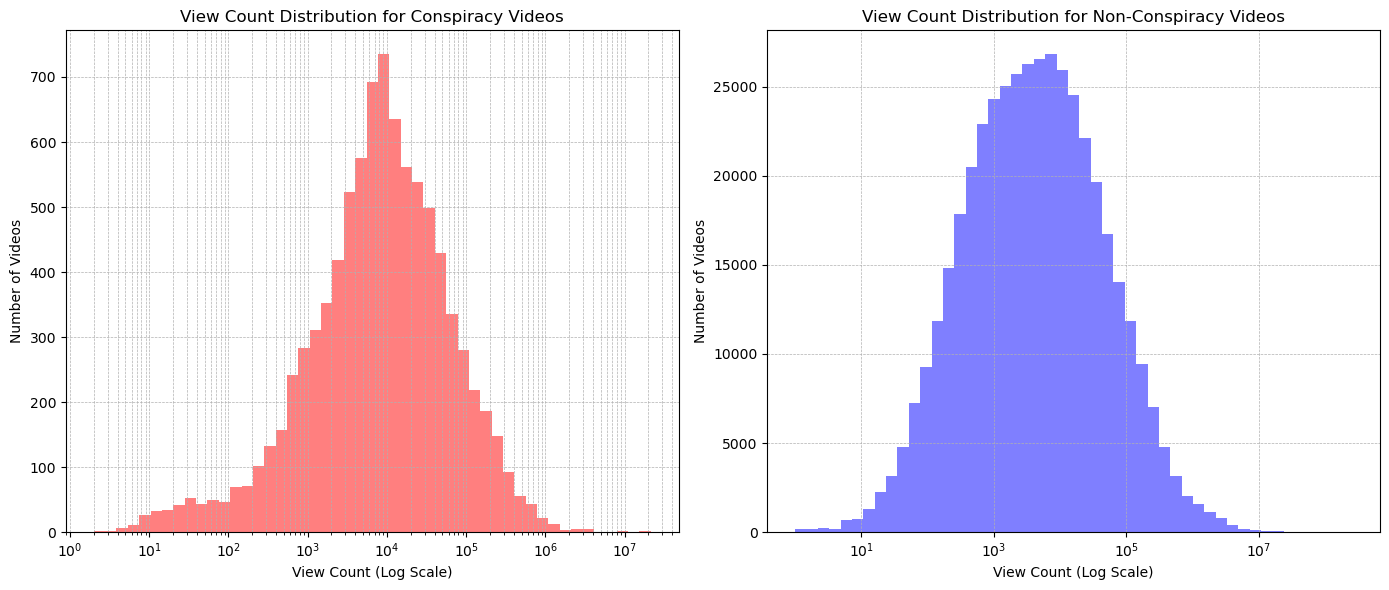

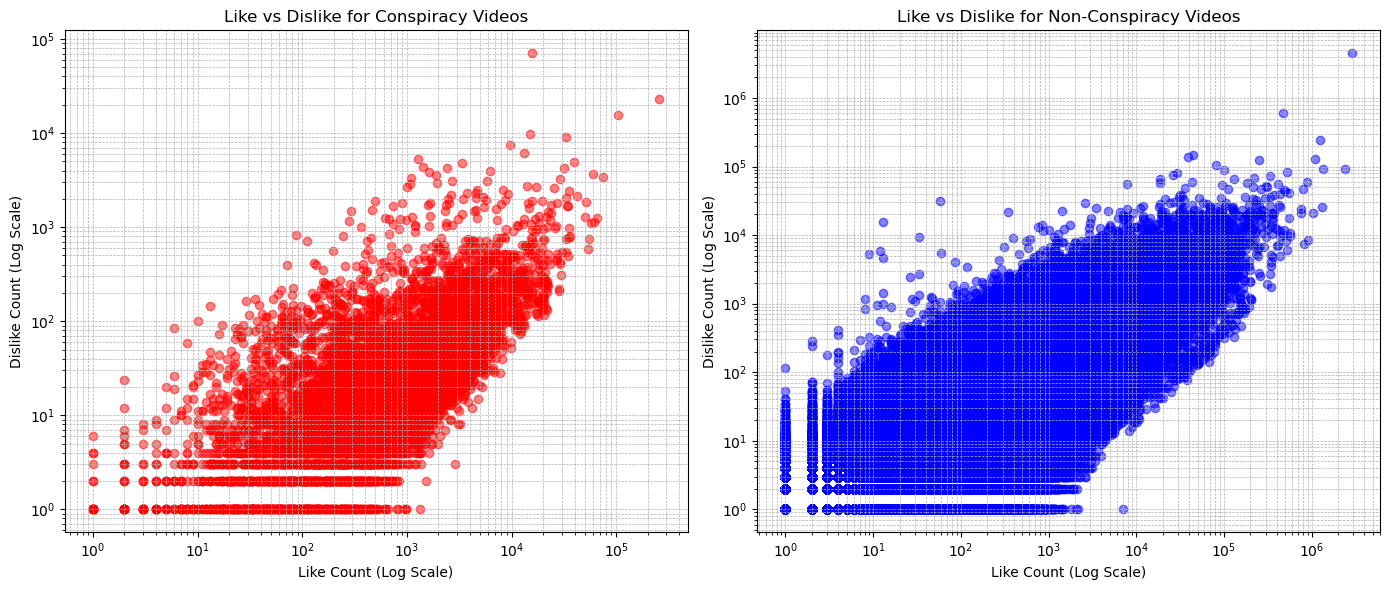

/tmp/ipykernel_352489/1738250077.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspiracy_df['like_dislike_ratio'] = like_count_conspiracy / dislike_count_conspiracy
/tmp/ipykernel_352489/1738250077.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_conspiracy_df['like_dislike_ratio'] = like_count_non_conspiracy / dislike_count_non_conspiracy


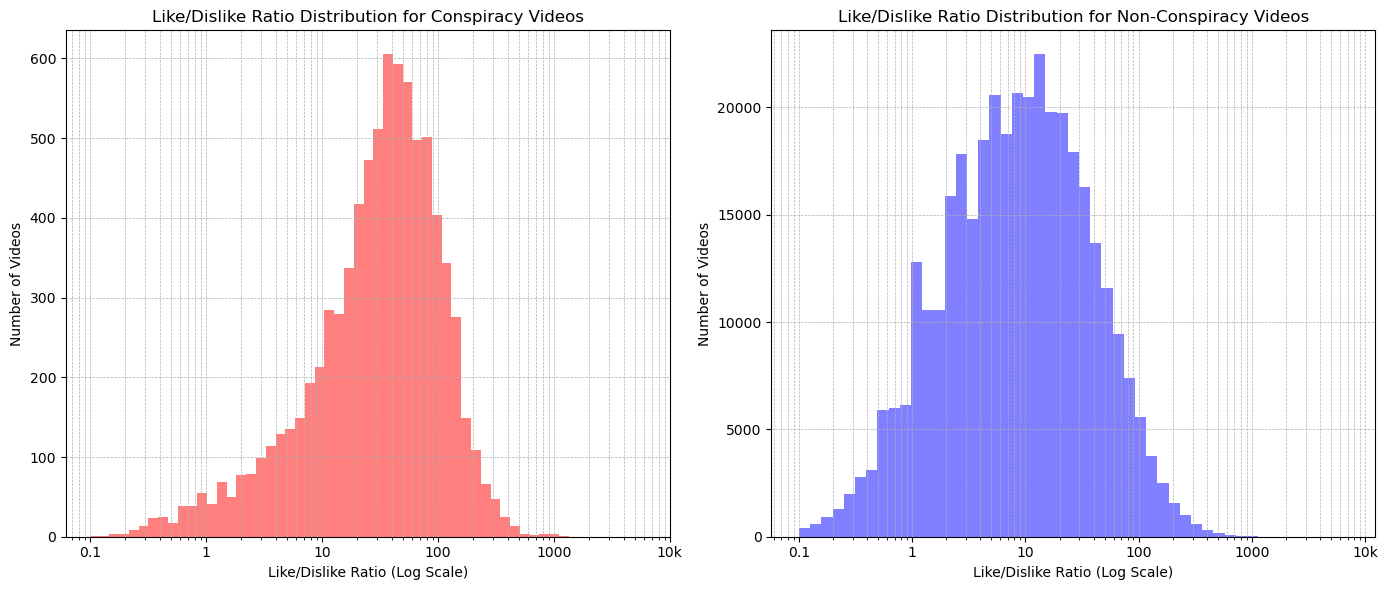

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Filter conspiracy and non-conspiracy DataFrames
conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]
non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]

# Plot 1: View Count Distribution (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
view_counts_conspiracy = conspiracy_df['view_count']
view_counts_conspiracy = view_counts_conspiracy[view_counts_conspiracy > 0]
plt.hist(view_counts_conspiracy, bins=np.logspace(np.log10(view_counts_conspiracy.min()), np.log10(view_counts_conspiracy.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
view_counts_non_conspiracy = non_conspiracy_df['view_count']
view_counts_non_conspiracy = view_counts_non_conspiracy[view_counts_non_conspiracy > 0]
plt.hist(view_counts_non_conspiracy, bins=np.logspace(np.log10(view_counts_non_conspiracy.min()), np.log10(view_counts_non_conspiracy.max()), 50), alpha=0.5, color='b')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot 2: Like vs Dislike Scatter Plot (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
plt.scatter(conspiracy_df['like_count'], conspiracy_df['dislike_count'], color='r', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Dislike Count (Log Scale)')
plt.title('Like vs Dislike for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
plt.scatter(non_conspiracy_df['like_count'], non_conspiracy_df['dislike_count'], color='b', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Dislike Count (Log Scale)')
plt.title('Like vs Dislike for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot 3: Like/Dislike Ratio Distribution (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
like_count_conspiracy = conspiracy_df['like_count']
dislike_count_conspiracy = conspiracy_df['dislike_count'].replace(0, np.nan)
conspiracy_df['like_dislike_ratio'] = like_count_conspiracy / dislike_count_conspiracy
ratio_data_conspiracy = conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_conspiracy, bins=np.logspace(-1, np.log10(ratio_data_conspiracy.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100, 1000, 10000], labels=[0.1, 1, 10, 100, 1000, '10k'])
plt.xlabel('Like/Dislike Ratio (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
like_count_non_conspiracy = non_conspiracy_df['like_count']
dislike_count_non_conspiracy = non_conspiracy_df['dislike_count'].replace(0, np.nan)
non_conspiracy_df['like_dislike_ratio'] = like_count_non_conspiracy / dislike_count_non_conspiracy
ratio_data_non_conspiracy = non_conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_non_conspiracy, bins=np.logspace(-1, np.log10(ratio_data_non_conspiracy.max()), 50), alpha=0.5, color='b')
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100, 1000, 10000], labels=[0.1, 1, 10, 100, 1000, '10k'])
plt.xlabel('Like/Dislike Ratio (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [40]:
from scipy import stats

# Make sure view_count is not NaN
conspiracy_view_counts = conspiracy_df['view_count'].dropna()
non_conspiracy_view_counts = non_conspiracy_df['view_count'].dropna()

# Perform two-sided t-test
t_stat, p_value_two_sided = stats.ttest_ind(conspiracy_view_counts, non_conspiracy_view_counts, equal_var=False)

# Convert to one-sided p-value
# We're interested in whether conspiracy videos have *more* views, so we halve the two-sided p-value if t-statistic is positive
if t_stat > 0:
    p_value_one_sided = p_value_two_sided / 2
else:
    p_value_one_sided = 1 - (p_value_two_sided / 2)

print(f"T-statistic: {t_stat}, one-sided p-value: {p_value_one_sided}")

# Interpret the results for one-sided test
if p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly more view counts than non-conspiracy videos.")
elif 1 - p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly less view counts than non-conspiracy videos.")
else:
    print("Results are not significant: No significant evidence that conspiracy videos have more view counts than non-conspiracy videos.")


T-statistic: -5.049657598512491, one-sided p-value: 0.9999997754795166
Results are significant: Conspiracy videos have significantly less view counts than non-conspiracy videos.


In [37]:
from scipy import stats
import numpy as np

# Make copies to avoid SettingWithCopyWarning
conspiracy_df = conspiracy_df.copy()
non_conspiracy_df = non_conspiracy_df.copy()

# Drop missing values (NaN) in like_count and dislike_count
conspiracy_like_count = conspiracy_df['like_count'].dropna()
non_conspiracy_like_count = non_conspiracy_df['like_count'].dropna()

conspiracy_dislike_count = conspiracy_df['dislike_count'].dropna()
non_conspiracy_dislike_count = non_conspiracy_df['dislike_count'].dropna()

# Perform t-tests after filtering out zero or constant values
if len(conspiracy_like_count.unique()) > 1 and len(non_conspiracy_like_count.unique()) > 1:
    # T-test - Like Count
    t_stat_like, p_value_like = stats.ttest_ind(conspiracy_like_count, non_conspiracy_like_count, equal_var=False)
    print(f"Like Count - T-statistic: {t_stat_like}, p-value: {p_value_like}")

    if p_value_like < 0.05:
        if t_stat_like > 0:
            print("Conspiracy videos have significantly more likes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more likes than conspiracy videos.")
    else:
        print("No significant difference in like count between conspiracy and non-conspiracy videos.")
else:
    print("Like Count: One or both groups have zero variance, cannot perform t-test.")

if len(conspiracy_dislike_count.unique()) > 1 and len(non_conspiracy_dislike_count.unique()) > 1:
    # T-test - Dislike Count
    t_stat_dislike, p_value_dislike = stats.ttest_ind(conspiracy_dislike_count, non_conspiracy_dislike_count, equal_var=False)
    print(f"\nDislike Count - T-statistic: {t_stat_dislike}, p-value: {p_value_dislike}")

    if p_value_dislike < 0.05:
        if t_stat_dislike > 0:
            print("Conspiracy videos have significantly more dislikes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more dislikes than conspiracy videos.")
    else:
        print("No significant difference in dislike count between conspiracy and non-conspiracy videos.")
else:
    print("Dislike Count: One or both groups have zero variance, cannot perform t-test.")

# Drop missing values (NaN) in like_dislike_rate
conspiracy_like_dislike_rate = conspiracy_df['like_dislike_rate'].dropna()
non_conspiracy_like_dislike_rate = non_conspiracy_df['like_dislike_rate'].dropna()

if len(conspiracy_like_dislike_rate.unique()) > 1 and len(non_conspiracy_like_dislike_rate.unique()) > 1:
    # T-test - Like-Dislike Rate
    t_stat_rate, p_value_rate = stats.ttest_ind(conspiracy_like_dislike_rate, non_conspiracy_like_dislike_rate, equal_var=False)
    print(f"\nLike-Dislike Rate - T-statistic: {t_stat_rate}, p-value: {p_value_rate}")

    if p_value_rate < 0.05:
        if t_stat_rate > 0:
            print("Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have a significantly higher like-dislike ratio than conspiracy videos.")
    else:
        print("No significant difference in the like-dislike ratio between conspiracy and non-conspiracy videos.")
else:
    print("Like-Dislike Rate: One or both groups have zero variance, cannot perform t-test.")


Like Count - T-statistic: 8.339311096321895, p-value: 8.387765639887809e-17
Conspiracy videos have significantly more likes than non-conspiracy videos.

Dislike Count - T-statistic: -2.5887710403423188, p-value: 0.009634884358680483
Non-conspiracy videos have significantly more dislikes than conspiracy videos.

Like-Dislike Rate - T-statistic: 43.488296978122136, p-value: 0.0
Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.


In [44]:
import pandas as pd

# Assuming df_combined_with_conspiracy is the given dataset

# Step 1: Filter only conspiracy-related videos
conspiracy_videos = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]

# Step 2: Group by channel and calculate total views
channel_view_counts = conspiracy_videos.groupby('channel')['view_count'].sum().reset_index()

# Step 3: Calculate market share based on view counts
total_views = channel_view_counts['view_count'].sum()
channel_view_counts['market_share'] = (channel_view_counts['view_count'] / total_views) * 100

# Sort by market share in descending order
channel_view_counts = channel_view_counts.sort_values(by='market_share', ascending=False).reset_index(drop=True)

# Display the top channels producing conspiracy-related videos by market share
print("Top channels producing conspiracy-related videos (by views):")
print(channel_view_counts.head(10))
total_market_share_top_10 = channel_view_counts.head(10)['market_share'].sum()
print(f"\nTotal market share of the top 10 channels: {total_market_share_top_10:.2f}%")

Top channels producing conspiracy-related videos (by views):
                    channel    view_count  market_share
0  UCXIJGQNII2ZOINSWNOGFTHA 47,822,411.00         11.26
1  UC2NQYGJFE9I_TGWPQGJORUG 34,026,586.00          8.01
2  UCZS3-65Y91JHOXFIM7J6GRG 21,398,032.00          5.04
3  UCVIXJTAXUNDMPUGDOPCY8AG 20,253,734.00          4.77
4  UCZFSNQ-Q7QV6KBSW9ZCOVXG 15,960,941.00          3.76
5  UC1YBKRUGPC1TSM73A0ZJYJQ 15,409,184.00          3.63
6  UCSV4YOF2RBYH0NQ1VUHQ-HG 15,126,115.00          3.56
7  UCAXKIU1QIDJPWIAYU6GCHJG 13,076,221.00          3.08
8  UCLONQH9RCNDFUGOB2F7E1EW 11,655,049.00          2.74
9  UCTWMWJR2BFPKUJTNSVCESSQ 10,800,406.00          2.54

Total market share of the top 10 channels: 48.41%


In [45]:
print("Top channels producing conspiracy-related videos (by views):")
top_channels = channel_view_counts.head(10)
print(top_channels)

# Calculate and print the total market share of the top 10 channels
total_market_share_top_10 = top_channels['market_share'].sum()
print(f"\nTotal market share of the top 10 channels: {total_market_share_top_10:.2f}%")

# Step 5: Get additional information (categories and subscribers) for top 10 channels
top_channels_info = df_combined_with_conspiracy[df_combined_with_conspiracy['channel'].isin(top_channels['channel'])][['channel', 'categories', 'subscribers_cc']].drop_duplicates()

# Display the categories and subscribers information for the top 10 channels
print("\nCategories and Subscribers for the Top 10 Channels Producing Conspiracy-Related Videos:")
print(top_channels_info)

Top channels producing conspiracy-related videos (by views):
                    channel    view_count  market_share
0  UCXIJGQNII2ZOINSWNOGFTHA 47,822,411.00         11.26
1  UC2NQYGJFE9I_TGWPQGJORUG 34,026,586.00          8.01
2  UCZS3-65Y91JHOXFIM7J6GRG 21,398,032.00          5.04
3  UCVIXJTAXUNDMPUGDOPCY8AG 20,253,734.00          4.77
4  UCZFSNQ-Q7QV6KBSW9ZCOVXG 15,960,941.00          3.76
5  UC1YBKRUGPC1TSM73A0ZJYJQ 15,409,184.00          3.63
6  UCSV4YOF2RBYH0NQ1VUHQ-HG 15,126,115.00          3.56
7  UCAXKIU1QIDJPWIAYU6GCHJG 13,076,221.00          3.08
8  UCLONQH9RCNDFUGOB2F7E1EW 11,655,049.00          2.74
9  UCTWMWJR2BFPKUJTNSVCESSQ 10,800,406.00          2.54

Total market share of the top 10 channels: 48.41%

Categories and Subscribers for the Top 10 Channels Producing Conspiracy-Related Videos:
                         channel             categories  subscribers_cc
339     UCZS3-65Y91JHOXFIM7J6GRG          Entertainment         2660000
343     UCZS3-65Y91JHOXFIM7J6GRG       

In [53]:
import pandas as pd

# Assuming df_combined_with_conspiracy is the given dataset

# Step 1: Filter only conspiracy-related videos
conspiracy_videos = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]

# Step 2: Group by channel and calculate total views and number of videos
channel_stats = conspiracy_videos.groupby('channel').agg(
    total_views=('view_count', 'sum'),
    video_count=('view_count', 'count')
).reset_index()

# Step 3: Calculate view count per video
channel_stats['view_count_per_video'] = channel_stats['total_views'] / channel_stats['video_count']

# Step 4: Sort by view count per video in descending order
channel_stats_sorted = channel_stats.sort_values(by='view_count_per_video', ascending=False).reset_index(drop=True)

# Display the top 10 channels producing conspiracy-related videos ranked by view count per video count
print("Top 10 channels producing conspiracy-related videos by view count per video:")
print(channel_stats_sorted.head(10))

# Optionally, display total market share for these top 10 channels
top_10_channels = channel_stats_sorted.head(10)
total_market_share_top_10 = (top_10_channels['total_views'].sum() / channel_stats['total_views'].sum()) * 100
print(f"\nTotal market share of the top 10 channels by view count per video: {total_market_share_top_10:.2f}%")


Top 10 channels producing conspiracy-related videos by view count per video:
                    channel   total_views  video_count  view_count_per_video
0  UCZS3-65Y91JHOXFIM7J6GRG 21,398,032.00            2         10,699,016.00
1  UCTWMWJR2BFPKUJTNSVCESSQ 10,800,406.00            2          5,400,203.00
2  UCWWHS_6X42TYRM4WSTOQ8HA  3,904,892.00            1          3,904,892.00
3  UCMTFAI84EHTSYSE9XOHEFIG  2,536,625.00            1          2,536,625.00
4  UCLFSU9_BUB4RC6OYFTT5SPW  9,192,499.00            6          1,532,083.17
5  UCP0HYYBW6IMAYGGR-WEOCVQ  1,293,925.00            1          1,293,925.00
6  UCLXO7UDZVBYW2IXZPQCUFNA  2,240,993.00            2          1,120,496.50
7  UCDFE_YKNRF4XM7W_SWBCXTW    825,768.00            1            825,768.00
8  UCPA-ZB0ZCQJTCPP1DX_1M8Q    775,418.00            1            775,418.00
9  UCZBY6V8LXMWU8GGRBOYO11W    724,175.00            1            724,175.00

Total market share of the top 10 channels by view count per video: 12.65%


In [52]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Assuming df_combined_with_conspiracy is the given dataset

# Step 1: Filter only conspiracy-related videos
conspiracy_videos = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]

# Step 2: Group by channel and calculate total views and number of videos
channel_stats = conspiracy_videos.groupby('channel').agg(
    total_views=('view_count', 'sum'),
    video_count=('view_count', 'count'),
    subscribers_cc=('subscribers_cc', 'first')
).reset_index()

# Step 3: Calculate view count per video
channel_stats['view_count_per_video'] = channel_stats['total_views'] / channel_stats['video_count']

# Step 4: Sort by view count per video and select the top 20 channels
channel_stats_sorted = channel_stats.sort_values(by='view_count_per_video', ascending=False).reset_index(drop=True)
top_20_channels = channel_stats_sorted.head(20)['channel']

# Step 5: Create a binary label indicating whether a channel is in the top 20 by view count per video
channel_stats['is_top_20'] = channel_stats['channel'].isin(top_20_channels).astype(int)

# Step 6: Prepare data for logistic regression
X = channel_stats[['subscribers_cc']]
X = sm.add_constant(X)  # Add a constant for the intercept in logistic regression
y = channel_stats['is_top_20']

# Step 7: Fit logistic regression model using statsmodels to analyze the relationship
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Step 8: Print the summary of the model
print(result.summary())

# Optional: Interpret the coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept', 'subscribers_cc'],
    'Coefficient': result.params
})
print("\nLogistic Regression Coefficients:")
print(coefficients)

# Odds ratio interpretation
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:")
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.103165
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              is_top_20   No. Observations:                  795
Model:                          Logit   Df Residuals:                      793
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                  0.1219
Time:                        23:14:00   Log-Likelihood:                -82.016
converged:                       True   LL-Null:                       -93.398
Covariance Type:            nonrobust   LLR p-value:                 1.831e-06
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.0045      0.268    -14.924      0.000      -4.530      -3.479
subscribers_cc  3